1. Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)

In [6]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [34]:
file_list = drive.ListFile({'q': "'1fMF50dmSqhPcH_JYMzfS50LftFcM4Ira' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: ratings_Electronics.csv, id: 1ea01wdy1-h7bsEcUn86HKOQJE_NKSqPa
title: Project6_recommendation_sys.ipynb, id: 1Hm2hfdfuoAwBfb1sQbHFpDZ7M1C2fvKp


In [0]:
train_downloaded = drive.CreateFile({'id': '1ea01wdy1-h7bsEcUn86HKOQJE_NKSqPa'})
train_downloaded.GetContentFile('ratings_Electronics.csv')

In [36]:
import pandas as pd
import numpy as np
columns=['userId', 'productId', 'ratings','timestamp']
df_train = pd.read_csv('ratings_Electronics.csv',names=columns)
df_train

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
...,...,...,...,...
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [37]:
df_train.shape

(7824482, 4)


Dropping the timestamp column

In [0]:
df_train.drop('timestamp',axis=1,inplace=True)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [40]:
#Check the number of rows and columns
rows,columns=df_train.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [0]:
#Taking subset of the dataset
df_train1=df_train.iloc[:50000,0:]

In [42]:

df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
userId       50000 non-null object
productId    50000 non-null object
ratings      50000 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [43]:
#Summary statistics of rating variable
df_train1['ratings'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: ratings, dtype: float64

In [44]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df_train1.ratings.min()))
print('Maximum rating is: %d' %(df_train1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [45]:
#Check for missing values
print('Number of missing values across columns: \n',df_train1.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


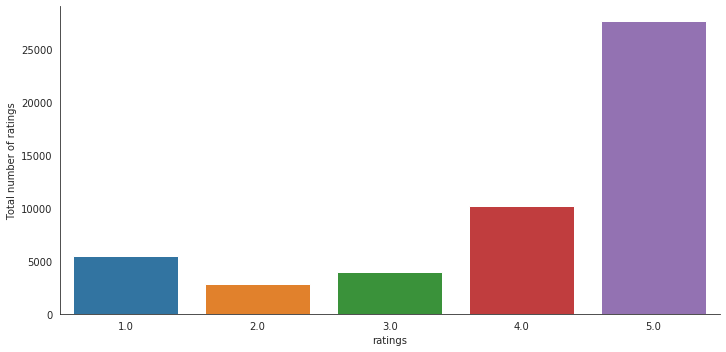

In [46]:

# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df_train1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [48]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', df_train1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', df_train1['productId'].nunique())

Number of unique users in Raw data =  46554
Number of unique product in Raw data =  3446


2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )

In [49]:
#Check the top 10 users based on ratings
most_rated=df_train1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    37
AY8Q1X7G96HV5     31
ALUNVOQRXOZIA     20
A1NVD0TKNS1GT5    19
A243HY69GIAHFI    18
A1RPTVW5VEOSI     17
A1ISUNUWG0K02V    16
A1MJMYLRTZ76ZX    16
A23ZO1BVFFLGHO    15
A7Y6AVS576M03     15
dtype: int64


In [50]:
counts=df_train1.userId.value_counts()
df_train1_final=df_train1[df_train1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(df_train1_final))
print('Number of unique users in the final data = ', df_train1_final['userId'].nunique())
print('Number of unique products in the final data = ', df_train1_final['userId'].nunique())

Number of users who have rated 25 or more items = 219
Number of unique users in the final data =  11
Number of unique products in the final data =  11


In [51]:

#constructing the pivot table
final_ratings_matrix = df_train1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,B00000J3II,B00000J3Q1,B00000J3Q7,B00000J3T1,B00000J3T4,B00000J434,B00000J47A,B00000J4ER,B00000J4FS,B00000J4O2,B00000J4VA,B00000J570,B00000J579,B00000JBIA,B00000JBJQ,B00000JBK6,B00000JBUI,B00000JDEI,B00000JDKT,B00000JFDW,B00000JFJA,B00000JFMW,B00000JHVP,B00000JI2C,B00000JSES,B00000JSEW,B00000JSGF,B00000JX2V,B00000JYLO,B00000K1SD,...,B00004SD9J,B00004SD9P,B00004SD9Q,B00004SP9T,B00004SPCB,B00004SPUN,B00004SPUT,B00004SSRC,B00004SSRL,B00004SSRN,B00004SSRO,B00004SSRP,B00004SSRQ,B00004STHL,B00004SV25,B00004SX3Z,B00004SY4H,B00004SYB7,B00004SYVH,B00004SZ9L,B00004T0RC,B00004T1M1,B00004T1MB,B00004T1WX,B00004T1WZ,B00004TB3J,B00004TDL2,B00004TDN2,B00004TDN5,B00004TDPP,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [52]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (11, 186)


In [53]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  219
possible_num_of_ratings =  2046
density: 10.70%


3. Build Popularity Recommender model.

In [54]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = df_train1_final.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,1400599997,1
1,B00000DM9M,1
2,B00000J061,1
3,B00000J08C,1
4,B00000J0A2,1
5,B00000J0E8,1
6,B00000J1QZ,1
7,B00000J1US,1
8,B00000J3H5,1
9,B00000J3HB,1


In [55]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
111,B00004RC2D,5,1.0
134,B00004SB92,5,2.0
75,B00002SWHH,3,3.0
136,B00004SC3Y,3,4.0
138,B00004SCKA,3,5.0


In [0]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [57]:
find_recom = [13, 200, 8, 190, 400]
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 13

     userId   productId  score  rank
111      13  B00004RC2D      5   1.0
134      13  B00004SB92      5   2.0
75       13  B00002SWHH      3   3.0
136      13  B00004SC3Y      3   4.0
138      13  B00004SCKA      3   5.0


Here is the recommendation for the userId: 200

     userId   productId  score  rank
111     200  B00004RC2D      5   1.0
134     200  B00004SB92      5   2.0
75      200  B00002SWHH      3   3.0
136     200  B00004SC3Y      3   4.0
138     200  B00004SCKA      3   5.0


Here is the recommendation for the userId: 8

     userId   productId  score  rank
111       8  B00004RC2D      5   1.0
134       8  B00004SB92      5   2.0
75        8  B00002SWHH      3   3.0
136       8  B00004SC3Y      3   4.0
138       8  B00004SCKA      3   5.0


Here is the recommendation for the userId: 190

     userId   productId  score  rank
111     190  B00004RC2D      5   1.0
134     190  B00004SB92      5   2.0
75      190  B00002SWHH     

In [58]:
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

SyntaxError: ignored

In [59]:
pip install scikit-surprise

In [0]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import train_test_split

In [0]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(df_train1_final[['userId', 'productId', 'ratings']], reader)

4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [0]:
trainset, testset = train_test_split(data, test_size=.30)

5. Build Collaborative Filtering model.

In [63]:

algo = SVD()
algo.fit(trainset)

In [64]:
trainset.ur

defaultdict(list,
            {0: [(0, 4.0),
              (8, 5.0),
              (9, 5.0),
              (50, 5.0),
              (56, 4.0),
              (61, 1.0),
              (68, 4.0),
              (87, 5.0),
              (94, 5.0),
              (97, 5.0),
              (110, 4.0)],
             1: [(1, 5.0),
              (2, 4.0),
              (7, 5.0),
              (13, 4.0),
              (14, 4.0),
              (16, 5.0),
              (17, 4.0),
              (27, 4.0),
              (49, 4.0),
              (51, 4.0),
              (54, 5.0),
              (67, 5.0),
              (70, 3.0),
              (0, 5.0),
              (86, 5.0),
              (88, 3.0),
              (89, 4.0),
              (119, 4.0),
              (120, 4.0),
              (125, 2.0)],
             2: [(3, 4.0),
              (5, 5.0),
              (18, 3.0),
              (28, 5.0),
              (29, 5.0),
              (30, 3.0),
              (39, 5.0),
              (45, 3.0),
 

6. Evaluate the above model. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.

In [0]:
predictions = algo.test(testset)

In [0]:
test_pred

In [67]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0771


1.0770740436751731

7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.

In [0]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [75]:
top_5 = get_top_n(predictions,5)
top_5


defaultdict(list,
            {'A1ISUNUWG0K02V': [('B00004RC2D', 4.554898110954672),
              ('B00004SCKA', 4.396170473323076),
              ('B00000J1QZ', 4.266547615703103),
              ('B000023VUK', 4.266547615703103),
              ('B0000488VH', 4.266547615703103)],
             'A1MJMYLRTZ76ZX': [('B000031KIM', 4.611494585978935),
              ('B000021YUO', 4.559655311604149),
              ('B00004SP9T', 4.481658417586279),
              ('B000021YU8', 4.481658417586279),
              ('B00004TDN2', 4.481658417586279)],
             'A1NVD0TKNS1GT5': [('B00001ZWXA', 4.1971646681163595),
              ('B00004SB96', 4.0437461118980345),
              ('B00000JBK6', 4.0437461118980345),
              ('B00004RJYB', 4.0437461118980345),
              ('B00004SX3Z', 4.0437461118980345)],
             'A1RPTVW5VEOSI': [('B00004RC2D', 4.49280786391043),
              ('B00004TH2W', 4.31986755063992),
              ('B00000K3RO', 4.31986755063992),
              ('B00004SD

8. Summarise your insights.


Summarising insights.
The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.